In [1]:
import numpy as np
import torch
import scipy
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.patches as mpatches
import seaborn
seaborn.set(font='Arial')
plt.style.use('default')
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 11
rcParams['pdf.fonttype'] = 42
plt.rcParams.update({"text.color": 'k'})

import sys
sys.path.append('./')
import auxiliary_bed_functions as abf
chr_list = abf.getChrList()

date = '8_6_20' # Change this to today's date for output names.

input_dir = '../' # directory with input files
file_prefix = 'leiomyoma_HOSVD_final' # prefix used for input files
output_dir = '../' # directory to write output

In [2]:
def getMinDistance(value, some_list):
    min_d = abs(value - some_list[0])
    for i in range(1,len(some_list)):
        if(abs(value - some_list[i]) < min_d):
            min_d = abs(value - some_list[i])
    return min_d

def getDistribution(data_list, N, upper):
    """Obtain a histogram for the list over a given range.
    
    The region between 0 and upper will be binned into
    equally sized bins. There is an additional overflow bin
    that contains the number of elements beyond the upper 
    bound. The function assumes there are no negative entries.
    The bin values are scaled by the total number of
    elements in the input data list so that the bin values
    and overflow bin sum to 1.
    """
    L = len(data_list)
    distribution = [0.0 for i in range(N+1)]
    step = upper/N
    for l in range(L):
        for k in range(N):
            if(data_list[l] >= step*k and data_list[l] < step*(k+1)):
                distribution[k] += 1
                break
            elif(data_list[l] >= upper):
                distribution[-1] += 1
                break
    for k in range(N+1):
        distribution[k] /= L
    return distribution

In [3]:
# The intersected peak file. This can be obtained
# by intersecting the narrowPeak files for the two
# replicates using bedtools.
M_HOXA13_pool = abf.readBed(input_dir + '../Myo_HOXA13/M_intersect_h13v5_1e6FDR_peaks.narrowPeak')

In [4]:
# Obtain the center of the intersected peak regions.
# The center is defined as the average of the starting
# and ending coordinates.
M_H13_pool_summit = [[0.5*(M_HOXA13_pool[c][i][1] + M_HOXA13_pool[c][i][2]) for i in range(len(M_HOXA13_pool[c]))] for c in range(len(chr_list))]


In [5]:
# Read in the regions with increased histone modifications
# associated with active gene regulation in leiomyoma.
DeCET_leio_high = abf.readBed(input_dir + 'region_files/location_vector_4_differential_regions_neg.txt')

In [6]:
# For each of the altered regions obtain the distance
# to the nearest HOXA13 peak center.
distance_list_leio_regions = []
for c in range(len(chr_list)):
    for i in range(len(DeCET_leio_high[c])):
        distance_list_leio_regions.append(getMinDistance(0.5*(DeCET_leio_high[c][i][2] + DeCET_leio_high[c][i][1]), M_H13_pool_summit[c]))

In [7]:
# Get the histogram of distances.
print("Max distance: ", max(distance_list_leio_regions))
N = 10
upper_enhancer = 20000
distance_distribution_leio_regions =  getDistribution(distance_list_leio_regions, N, upper_enhancer)     
print("Mean distance: ", np.mean(distance_list_leio_regions))
print("Median distance: ", np.median(distance_list_leio_regions))

Max distance:  1553376.0
Mean distance:  47692.053630363036
Median distance:  12770.5


In [8]:
# Repeat for the regions with reduced histone modifications
# in leiomyoma (equivalently higher histone modifications
# in myometrium)
DeCET_myo_high = abf.readBed(input_dir + 'region_files/location_vector_4_differential_regions_pos.txt')

In [9]:
distance_list_myo_regions = []
for c in range(len(chr_list)):
    for i in range(len(DeCET_myo_high[c])):
        distance_list_myo_regions.append(getMinDistance(0.5*(DeCET_myo_high[c][i][2] + DeCET_myo_high[c][i][1]), M_H13_pool_summit[c]))

In [10]:
print("Max distance: ", max(distance_list_myo_regions))
N = 10
upper_enhancer = 20000
distance_distribution_myo_regions =  getDistribution(distance_list_myo_regions, N, upper_enhancer)     
print("Mean distance: ", np.mean(distance_list_myo_regions))
print("Median distance: ", np.median(distance_list_myo_regions))

Max distance:  464732.5
Mean distance:  18512.302067381315
Median distance:  6616.5


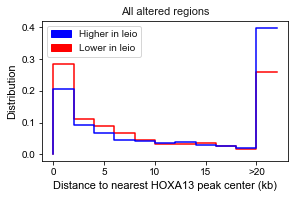

In [11]:
# Distribution of the distance to the
# nearest HOXA13 peak for regions with higer/lower
# histone modifications in leiomyoma
legend_TN = [mpatches.Patch(color=c, label=l) for c,l in zip([(0,0,1,1), (1,0,0,1)], ['Higher in leio', 'Lower in leio'])]
fig1 = plt.figure(1,figsize=(4.2, 2.85))
ax1 = fig1.add_subplot(111)  
fig1.canvas.draw()

ax1.plot([i*(upper_enhancer/N) for i in range(len(distance_distribution_myo_regions)+1)],
         [0] + distance_distribution_myo_regions,
         c=(1,0,0,1), ds='steps')
ax1.plot([i*(upper_enhancer/N) for i in range(len(distance_distribution_leio_regions)+1)],
         [0] + distance_distribution_leio_regions,
         c=(0,0,1,1), ds='steps')

a=ax1.get_xticks().tolist()
a[-2]='>20'
for i in range(len(a)-2):
    a[i] = int(int(a[i])/1000)
ax1.set_xticklabels(a)
ax1.set_xlabel('Distance to nearest HOXA13 peak center (kb)',fontsize=11)
#plt.ylim(0.0, 0.6)

ax1.legend(handles=legend_TN, frameon=True, fontsize=10, ncol=1)

ax1.set_ylabel('Distribution',fontsize=11)
plt.title('All altered regions',fontsize=11)
plt.tight_layout()

In [12]:
# Mann Whitney U test for the list of distances
# to the nearest HOXA13 peak.
scipy.stats.mannwhitneyu(distance_list_leio_regions,
                         distance_list_myo_regions,
                         alternative='two-sided')

MannwhitneyuResult(statistic=1413740.5, pvalue=8.062008272339623e-20)

In [13]:
# Read in sets of random histone modification ChIP-seq
# peaks. The random set of peaks was obtained by 
# pooling peaks from all 21 leiomyoma patients and 
# sampling 10000 random peaks for each histone modification.
Leio_H3K27ac_peaks = abf.readBed(input_dir + 'MACS2_peaks/Leio_H3K27ac_MACS2_10k_peaks.broadPeak')
Leio_H3K4me3_peaks = abf.readBed(input_dir + 'MACS2_peaks/Leio_H3K4me3_MACS2_10k_peaks.broadPeak')
Leio_H3K4me1_peaks = abf.readBed(input_dir + 'MACS2_peaks/Leio_H3K4me1_MACS2_10k_peaks.broadPeak')

In [14]:
# Compute the distance the the nearest HOXA13 peak 
# for each of the random peaks.
distance_list_leio_H3K27ac_random = []
for c in range(len(chr_list)):
    for i in range(len(Leio_H3K27ac_peaks[c])):
        center = 0.5*(Leio_H3K27ac_peaks[c][i][1] + Leio_H3K27ac_peaks[c][i][2])
        distance_list_leio_H3K27ac_random.append(getMinDistance(center, M_H13_pool_summit[c]))
        
distance_list_leio_H3K4me3_random = []
for c in range(len(chr_list)):
    for i in range(len(Leio_H3K4me3_peaks[c])):
        center = 0.5*(Leio_H3K4me3_peaks[c][i][1] + Leio_H3K4me3_peaks[c][i][2])
        distance_list_leio_H3K4me3_random.append(getMinDistance(center, M_H13_pool_summit[c]))
        
distance_list_leio_H3K4me1_random = []
for c in range(len(chr_list)):
    for i in range(len(Leio_H3K4me1_peaks[c])):
        center = 0.5*(Leio_H3K4me1_peaks[c][i][1] + Leio_H3K4me1_peaks[c][i][2])
        distance_list_leio_H3K4me1_random.append(getMinDistance(center, M_H13_pool_summit[c]))

In [15]:
# Get the histogram of distances for the random peak regions.
print("Max distance: ", max(distance_list_leio_H3K27ac_random))
N = 10
upper_enhancer = 20000
distance_distribution_leio_H3K27ac_random =  getDistribution(distance_list_leio_H3K27ac_random, N, upper_enhancer)     
print("Mean distance: ", np.mean(distance_list_leio_H3K27ac_random))
print("Median distance: ", np.median(distance_list_leio_H3K27ac_random))

print("Max distance: ", max(distance_list_leio_H3K4me3_random))
N = 10
upper_enhancer = 20000
distance_distribution_leio_H3K4me3_random =  getDistribution(distance_list_leio_H3K4me3_random, N, upper_enhancer)     
print("Mean distance: ", np.mean(distance_list_leio_H3K4me3_random))
print("Median distance: ", np.median(distance_list_leio_H3K4me3_random))

print("Max distance: ", max(distance_list_leio_H3K4me1_random))
N = 10
upper_enhancer = 20000
distance_distribution_leio_H3K4me1_random =  getDistribution(distance_list_leio_H3K4me1_random, N, upper_enhancer)     
print("Mean distance: ", np.mean(distance_list_leio_H3K4me1_random))
print("Median distance: ", np.median(distance_list_leio_H3K4me1_random))

Max distance:  1762719.5
Mean distance:  40990.2224
Median distance:  13553.5
Max distance:  1912678.5
Mean distance:  70856.4038
Median distance:  27950.0
Max distance:  2374275.5
Mean distance:  39579.69005
Median distance:  11404.25


In [16]:
# Read in sets of random histone modification ChIP-seq
# peaks. The random set of peaks was obtained by 
# pooling peaks from all 21 myometrium patients and 
# sampling 10000 random peaks for each histone modification.
Myo_H3K27ac_peaks = abf.readBed(input_dir + 'MACS2_peaks/Myo_H3K27ac_MACS2_10k_peaks.broadPeak')
Myo_H3K4me3_peaks = abf.readBed(input_dir + 'MACS2_peaks/Myo_H3K4me3_MACS2_10k_peaks.broadPeak')
Myo_H3K4me1_peaks = abf.readBed(input_dir + 'MACS2_peaks/Myo_H3K4me1_MACS2_10k_peaks.broadPeak')

In [17]:
# Compute the distance the the nearest HOXA13 peak 
# for each of the random peaks.
distance_list_myo_H3K27ac_random = []
for c in range(len(chr_list)):
    for i in range(len(Myo_H3K27ac_peaks[c])):
        center = 0.5*(Myo_H3K27ac_peaks[c][i][1] + Myo_H3K27ac_peaks[c][i][2])
        distance_list_myo_H3K27ac_random.append(getMinDistance(center, M_H13_pool_summit[c]))
        
distance_list_myo_H3K4me3_random = []
for c in range(len(chr_list)):
    if(c == 23):
        continue
    for i in range(len(Myo_H3K4me3_peaks[c])):
        center = 0.5*(Myo_H3K4me3_peaks[c][i][1] + Myo_H3K4me3_peaks[c][i][2])
        distance_list_myo_H3K4me3_random.append(getMinDistance(center, M_H13_pool_summit[c]))
        
distance_list_myo_H3K4me1_random = []
for c in range(len(chr_list)):
    for i in range(len(Myo_H3K4me1_peaks[c])):
        center = 0.5*(Myo_H3K4me1_peaks[c][i][1] + Myo_H3K4me1_peaks[c][i][2])
        distance_list_myo_H3K4me1_random.append(getMinDistance(center, M_H13_pool_summit[c]))

In [18]:
# Get the histogram of distances for the random peak regions.
print("Max distance: ", max(distance_list_myo_H3K27ac_random))
N = 10
upper_enhancer = 20000
distance_distribution_myo_H3K27ac_random =  getDistribution(distance_list_myo_H3K27ac_random, N, upper_enhancer)     
print("Mean distance: ", np.mean(distance_list_myo_H3K27ac_random))
print("Median distance: ", np.median(distance_list_myo_H3K27ac_random))

print("Max distance: ", max(distance_list_myo_H3K4me3_random))
N = 10
upper_enhancer = 20000
distance_distribution_myo_H3K4me3_random =  getDistribution(distance_list_myo_H3K4me3_random, N, upper_enhancer)     
print("Mean distance: ", np.mean(distance_list_myo_H3K4me3_random))
print("Median distance: ", np.median(distance_list_myo_H3K4me3_random))

print("Max distance: ", max(distance_list_myo_H3K4me1_random))
N = 10
upper_enhancer = 20000
distance_distribution_myo_H3K4me1_random =  getDistribution(distance_list_myo_H3K4me1_random, N, upper_enhancer)     
print("Mean distance: ", np.mean(distance_list_myo_H3K4me1_random))
print("Median distance: ", np.median(distance_list_myo_H3K4me1_random))

Max distance:  1925046.5
Mean distance:  39538.3522
Median distance:  13235.75
Max distance:  1769310.0
Mean distance:  71417.0728
Median distance:  28535.5
Max distance:  1925501.0
Mean distance:  35320.38305
Median distance:  11416.0


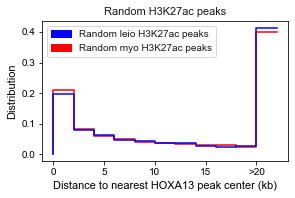

In [19]:
# Distribution of the distance to the nearest 
# HOXA13 peak for random H3K27ac peaks sampled 
# from leiomyoma or myometrium samples
legend_TN = [mpatches.Patch(color=c, label=l) for c,l in zip([(0,0,1,1), (1,0,0,1)], ['Random leio H3K27ac peaks', 'Random myo H3K27ac peaks'])]
fig1 = plt.figure(1,figsize=(4.2, 2.85))
ax1 = fig1.add_subplot(111)  
fig1.canvas.draw()

ax1.plot([i*(upper_enhancer/N) for i in range(len(distance_distribution_myo_H3K27ac_random)+1)],
         [0] + distance_distribution_myo_H3K27ac_random,
         c=(1,0,0,1), ds='steps')
ax1.plot([i*(upper_enhancer/N) for i in range(len(distance_distribution_leio_H3K27ac_random)+1)],
         [0] + distance_distribution_leio_H3K27ac_random,
         c=(0,0,1,1), ds='steps')

a=ax1.get_xticks().tolist()
a[-2]='>20'
for i in range(len(a)-2):
    a[i] = int(int(a[i])/1000)
ax1.set_xticklabels(a)
ax1.set_xlabel('Distance to nearest HOXA13 peak center (kb)',fontsize=11)
#plt.ylim(0.0, 0.6)

ax1.legend(handles=legend_TN, frameon=True, fontsize=10, ncol=1)

ax1.set_ylabel('Distribution',fontsize=11)
plt.title('Random H3K27ac peaks',fontsize=11)
plt.tight_layout()

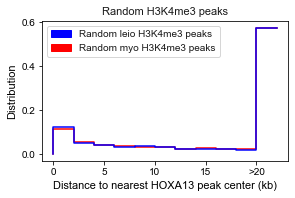

In [20]:
# Distribution of the distance to the nearest 
# HOXA13 peak for random H3K4me3 peaks sampled 
# from leiomyoma or myometrium samples
legend_TN = [mpatches.Patch(color=c, label=l) for c,l in zip([(0,0,1,1), (1,0,0,1)], ['Random leio H3K4me3 peaks', 'Random myo H3K4me3 peaks'])]
fig1 = plt.figure(1,figsize=(4.2, 2.85))
ax1 = fig1.add_subplot(111)  
fig1.canvas.draw()

ax1.plot([i*(upper_enhancer/N) for i in range(len(distance_distribution_myo_H3K4me3_random)+1)],
         [0] + distance_distribution_myo_H3K4me3_random,
         c=(1,0,0,1), ds='steps')
ax1.plot([i*(upper_enhancer/N) for i in range(len(distance_distribution_leio_H3K4me3_random)+1)],
         [0] + distance_distribution_leio_H3K4me3_random,
         c=(0,0,1,1), ds='steps')

a=ax1.get_xticks().tolist()
a[-2]='>20'
for i in range(len(a)-2):
    a[i] = int(int(a[i])/1000)
ax1.set_xticklabels(a)
ax1.set_xlabel('Distance to nearest HOXA13 peak center (kb)',fontsize=11)
#plt.ylim(0.0, 0.6)

ax1.legend(handles=legend_TN, frameon=True, fontsize=10, ncol=1)

ax1.set_ylabel('Distribution',fontsize=11)
plt.title('Random H3K4me3 peaks',fontsize=11)
plt.tight_layout()

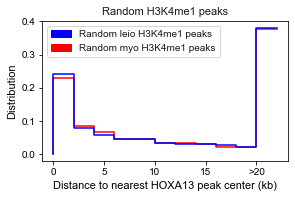

In [21]:
# Distribution of the distance to the nearest 
# HOXA13 peak for random H3K4me1 peaks sampled 
# from leiomyoma or myometrium samples
legend_TN = [mpatches.Patch(color=c, label=l) for c,l in zip([(0,0,1,1), (1,0,0,1)], ['Random leio H3K4me1 peaks', 'Random myo H3K4me1 peaks'])]
fig1 = plt.figure(1,figsize=(4.2, 2.85))
ax1 = fig1.add_subplot(111)  
fig1.canvas.draw()

ax1.plot([i*(upper_enhancer/N) for i in range(len(distance_distribution_myo_H3K4me1_random)+1)],
         [0] + distance_distribution_myo_H3K4me1_random,
         c=(1,0,0,1), ds='steps')
ax1.plot([i*(upper_enhancer/N) for i in range(len(distance_distribution_leio_H3K4me1_random)+1)],
         [0] + distance_distribution_leio_H3K4me1_random,
         c=(0,0,1,1), ds='steps')

a=ax1.get_xticks().tolist()
a[-2]='>20'
for i in range(len(a)-2):
    a[i] = int(int(a[i])/1000)
ax1.set_xticklabels(a)
ax1.set_xlabel('Distance to nearest HOXA13 peak center (kb)',fontsize=11)
#plt.ylim(0.0, 0.6)

ax1.legend(handles=legend_TN, frameon=True, fontsize=10, ncol=1)

ax1.set_ylabel('Distribution',fontsize=11)
plt.title('Random H3K4me1 peaks',fontsize=11)
plt.tight_layout()

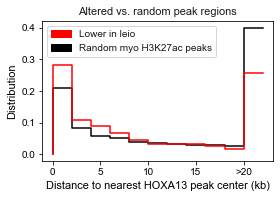

In [22]:
# Figure 5E: Distribution of the distance to the
# nearest HOXA13 peak for the regions with lower 
# histone modifications in leiomyoma or for random
# H3K27ac peaks sampled from myometrium samples.
legend_TN = [mpatches.Patch(color=c, label=l) for c,l in zip([(1,0,0,1), (0,0,0,1)], ['Lower in leio', 'Random myo H3K27ac peaks'])]
# fig1 = plt.figure(1,figsize=(4.2, 2.85))
# fig1 = plt.figure(1,figsize=(3.7, 2.85))
fig1 = plt.figure(1,figsize=(4.0, 2.85))
ax1 = fig1.add_subplot(111)  
fig1.canvas.draw()

ax1.plot([i*(upper_enhancer/N) for i in range(len(distance_distribution_myo_H3K27ac_random)+1)],
         [0] + distance_distribution_myo_H3K27ac_random,
         c=(0,0,0,1), ds='steps')
ax1.plot([i*(upper_enhancer/N) for i in range(len(distance_distribution_myo_regions)+1)],
         [0] + distance_distribution_myo_regions,
         c=(1,0,0,1), ds='steps')

a=ax1.get_xticks().tolist()
a[-2]='>20'
for i in range(len(a)-2):
    a[i] = int(int(a[i])/1000)
ax1.set_xticklabels(a)
ax1.set_xlabel('Distance to nearest HOXA13 peak center (kb)',fontsize=11)
#plt.ylim(0.0, 0.6)

ax1.legend(handles=legend_TN, frameon=True, fontsize=10, ncol=1)

ax1.set_ylabel('Distribution',fontsize=11)
plt.title('Altered vs. random peak regions',fontsize=11)
plt.tight_layout()

plt.savefig(output_dir + 'figures/' + 'figure5_panels/' + file_prefix +
            '_panelE_HOXA13_lower_leio_dist_' + date + '.pdf', format='pdf', transparent=True)

In [23]:
# Mann Whitney U test for the list of distances
# to regions with lower histone modifications in
# leiomyoma vs random H3K27ac peaks from myometrium
# samples.
scipy.stats.mannwhitneyu(distance_list_myo_H3K27ac_random,
                         distance_list_myo_regions,
                         alternative='two-sided')

MannwhitneyuResult(statistic=7754685.0, pvalue=2.4499931664299094e-28)

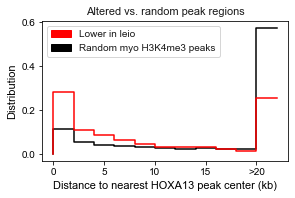

In [24]:
# Distribution of the distance to the
# nearest HOXA13 peak for the regions with lower 
# histone modifications in leiomyoma or for random
# H3K4me3 peaks sampled from myometrium samples.
legend_TN = [mpatches.Patch(color=c, label=l) for c,l in zip([(1,0,0,1), (0,0,0,1)], ['Lower in leio', 'Random myo H3K4me3 peaks'])]
fig1 = plt.figure(1,figsize=(4.2, 2.85))
ax1 = fig1.add_subplot(111)  
fig1.canvas.draw()

ax1.plot([i*(upper_enhancer/N) for i in range(len(distance_distribution_myo_H3K4me3_random)+1)],
         [0] + distance_distribution_myo_H3K4me3_random,
         c=(0,0,0,1), ds='steps')
ax1.plot([i*(upper_enhancer/N) for i in range(len(distance_distribution_myo_regions)+1)],
         [0] + distance_distribution_myo_regions,
         c=(1,0,0,1), ds='steps')

a=ax1.get_xticks().tolist()
a[-2]='>20'
for i in range(len(a)-2):
    a[i] = int(int(a[i])/1000)
ax1.set_xticklabels(a)
ax1.set_xlabel('Distance to nearest HOXA13 peak center (kb)',fontsize=11)
#plt.ylim(0.0, 0.6)

ax1.legend(handles=legend_TN, frameon=True, fontsize=10, ncol=1)

ax1.set_ylabel('Distribution',fontsize=11)
plt.title('Altered vs. random peak regions',fontsize=11)
plt.tight_layout()

In [25]:
# Mann Whitney U test for the list of distances
# to regions with lower histone modifications in
# leiomyoma vs random H3K4me3 peaks from myometrium
# samples.
scipy.stats.mannwhitneyu(distance_list_myo_H3K4me3_random,
                         distance_list_myo_regions,
                         alternative='two-sided')

MannwhitneyuResult(statistic=9311185.5, pvalue=1.0252872810562156e-138)

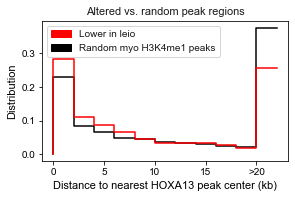

In [26]:
# Distribution of the distance to the
# nearest HOXA13 peak for the regions with lower 
# histone modifications in leiomyoma or for random
# H3K4me1 peaks sampled from myometrium samples.
legend_TN = [mpatches.Patch(color=c, label=l) for c,l in zip([(1,0,0,1), (0,0,0,1)], ['Lower in leio', 'Random myo H3K4me1 peaks'])]
fig1 = plt.figure(1,figsize=(4.2, 2.85))
ax1 = fig1.add_subplot(111)  
fig1.canvas.draw()

ax1.plot([i*(upper_enhancer/N) for i in range(len(distance_distribution_myo_H3K4me1_random)+1)],
         [0] + distance_distribution_myo_H3K4me1_random,
         c=(0,0,0,1), ds='steps')
ax1.plot([i*(upper_enhancer/N) for i in range(len(distance_distribution_myo_regions)+1)],
         [0] + distance_distribution_myo_regions,
         c=(1,0,0,1), ds='steps')

a=ax1.get_xticks().tolist()
a[-2]='>20'
for i in range(len(a)-2):
    a[i] = int(int(a[i])/1000)
ax1.set_xticklabels(a)
ax1.set_xlabel('Distance to nearest HOXA13 peak center (kb)',fontsize=11)
#plt.ylim(0.0, 0.6)

ax1.legend(handles=legend_TN, frameon=True, fontsize=10, ncol=1)

ax1.set_ylabel('Distribution',fontsize=11)
plt.title('Altered vs. random peak regions',fontsize=11)
plt.tight_layout()

In [27]:
# Mann Whitney U test for the list of distances
# to regions with lower histone modifications in
# leiomyoma vs random H3K4me1 peaks from myometrium
# samples.
scipy.stats.mannwhitneyu(distance_list_myo_H3K4me1_random,
                         distance_list_myo_regions,
                         alternative='two-sided')

MannwhitneyuResult(statistic=7479590.0, pvalue=1.127232816124181e-17)

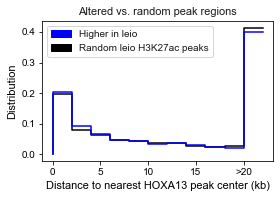

In [28]:
# Figure 5F: Distribution of the distance to the
# nearest HOXA13 peak for the regions with higher
# histone modifications in leiomyoma or for random
# H3K27ac peaks sampled from leiomyoma samples.
legend_TN = [mpatches.Patch(color=c, label=l) for c,l in zip([(0,0,1,1), (0,0,0,1)], ['Higher in leio', 'Random leio H3K27ac peaks'])]
# fig1 = plt.figure(1,figsize=(4.2, 2.85))
# fig1 = plt.figure(1,figsize=(3.7, 2.85))
fig1 = plt.figure(1,figsize=(4.0, 2.85))
ax1 = fig1.add_subplot(111)  
fig1.canvas.draw()

ax1.plot([i*(upper_enhancer/N) for i in range(len(distance_distribution_leio_H3K27ac_random)+1)],
         [0] + distance_distribution_leio_H3K27ac_random,
         c=(0,0,0,1), ds='steps')
ax1.plot([i*(upper_enhancer/N) for i in range(len(distance_distribution_leio_regions)+1)],
         [0] + distance_distribution_leio_regions,
         c=(0,0,1,1), ds='steps')

a=ax1.get_xticks().tolist()
a[-2]='>20'
for i in range(len(a)-2):
    a[i] = int(int(a[i])/1000)
ax1.set_xticklabels(a)
ax1.set_xlabel('Distance to nearest HOXA13 peak center (kb)',fontsize=11)
#plt.ylim(0.0, 0.6)

ax1.legend(handles=legend_TN, frameon=True, fontsize=10, ncol=1)

ax1.set_ylabel('Distribution',fontsize=11)
plt.title('Altered vs. random peak regions',fontsize=11)
plt.tight_layout()
plt.savefig(output_dir + 'figures/' + 'figure5_panels/' + file_prefix +
            '_panelF_HOXA13_higher_leio_dist_' + date + '.pdf', format='pdf', transparent=True)

In [29]:
# Mann Whitney U test for the list of distances
# to regions with higher histone modifications in
# leiomyoma vs random H3K27ac peaks from leiomyoma
# samples.
scipy.stats.mannwhitneyu(distance_list_leio_H3K27ac_random,
                         distance_list_leio_regions,
                         alternative='two-sided')

MannwhitneyuResult(statistic=9198463.0, pvalue=0.4176207961992572)

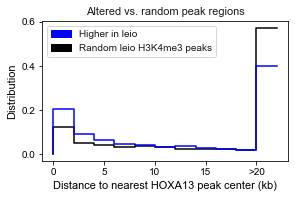

In [30]:
# Distribution of the distance to the
# nearest HOXA13 peak for the regions with higher 
# histone modifications in leiomyoma or for random
# H3K4me3 peaks sampled from leiomyoma samples
legend_TN = [mpatches.Patch(color=c, label=l) for c,l in zip([(0,0,1,1), (0,0,0,1)], ['Higher in leio', 'Random leio H3K4me3 peaks'])]
fig1 = plt.figure(1,figsize=(4.2, 2.85))
ax1 = fig1.add_subplot(111)  
fig1.canvas.draw()

ax1.plot([i*(upper_enhancer/N) for i in range(len(distance_distribution_leio_H3K4me3_random)+1)],
         [0] + distance_distribution_leio_H3K4me3_random,
         c=(0,0,0,1), ds='steps')
ax1.plot([i*(upper_enhancer/N) for i in range(len(distance_distribution_leio_regions)+1)],
         [0] + distance_distribution_leio_regions,
         c=(0,0,1,1), ds='steps')

a=ax1.get_xticks().tolist()
a[-2]='>20'
for i in range(len(a)-2):
    a[i] = int(int(a[i])/1000)
ax1.set_xticklabels(a)
ax1.set_xlabel('Distance to nearest HOXA13 peak center (kb)',fontsize=11)
#plt.ylim(0.0, 0.6)

ax1.legend(handles=legend_TN, frameon=True, fontsize=10, ncol=1)

ax1.set_ylabel('Distribution',fontsize=11)
plt.title('Altered vs. random peak regions',fontsize=11)
plt.tight_layout()

In [31]:
# Mann Whitney U test for the list of distances
# to regions with higher histone modifications in
# leiomyoma vs random H3K4me3 peaks from leiomyoma
# samples.
scipy.stats.mannwhitneyu(distance_list_leio_H3K4me3_random,
                         distance_list_leio_regions,
                         alternative='two-sided')

MannwhitneyuResult(statistic=11099059.5, pvalue=5.946419103007666e-51)

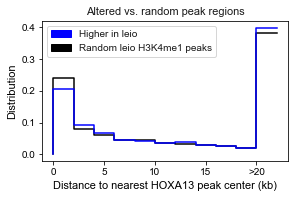

In [32]:
# Distribution of the distance to the
# nearest HOXA13 peak for the regions with higher 
# histone modifications in leiomyoma or for random
# H3K4me1 peaks sampled from leiomyoma samples
legend_TN = [mpatches.Patch(color=c, label=l) for c,l in zip([(0,0,1,1), (0,0,0,1)], ['Higher in leio', 'Random leio H3K4me1 peaks'])]
fig1 = plt.figure(1,figsize=(4.2, 2.85))
ax1 = fig1.add_subplot(111)  
fig1.canvas.draw()

ax1.plot([i*(upper_enhancer/N) for i in range(len(distance_distribution_leio_H3K4me1_random)+1)],
         [0] + distance_distribution_leio_H3K4me1_random,
         c=(0,0,0,1), ds='steps')
ax1.plot([i*(upper_enhancer/N) for i in range(len(distance_distribution_leio_regions)+1)],
         [0] + distance_distribution_leio_regions,
         c=(0,0,1,1), ds='steps')

a=ax1.get_xticks().tolist()
a[-2]='>20'
for i in range(len(a)-2):
    a[i] = int(int(a[i])/1000)
ax1.set_xticklabels(a)
ax1.set_xlabel('Distance to nearest HOXA13 peak center (kb)',fontsize=11)
#plt.ylim(0.0, 0.6)

ax1.legend(handles=legend_TN, frameon=True, fontsize=10, ncol=1)

ax1.set_ylabel('Distribution',fontsize=11)
plt.title('Altered vs. random peak regions',fontsize=11)
plt.tight_layout()

In [33]:
# Mann Whitney U test for the list of distances
# to regions with higher histone modifications in
# leiomyoma vs random H3K4me1 peaks from leiomyoma
# samples.
scipy.stats.mannwhitneyu(distance_list_leio_H3K4me1_random,
                         distance_list_leio_regions,
                         alternative='two-sided')

MannwhitneyuResult(statistic=8665021.5, pvalue=0.001493613313669459)